## Generating New Faces From Images

Training a VAE model to learn to generate fake human faces based on a dataset of real faces (CelebA Dataset). 

In order to run the notebook you have to download the CelebA dataset (total size of 1Gb) yourself. I used this version [https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg) hosted on Google Drive. The create the trainset I added the first 60k images to the `./data/CELEBA/train/person` folder. 

This notebook uses a deep convolutional VAE to learn. For the GAN version see the `celeba_gan.ipynb` notebook. 



In [37]:
# Import the required libraries
import torch
import torch.nn as nn 
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from models import VAELoss
from celeba_models import ConvVAE

In [38]:
# Hyperparameters for the training procedure
batch_size = 200
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

# Transformations applied to the initial images
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(64),
    torchvision.transforms.CenterCrop(64),
    torchvision.transforms.ToTensor()
])

# Load the images from the `data/CELEBA` folder
dataset = torchvision.datasets.ImageFolder('./data/CELEBA', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

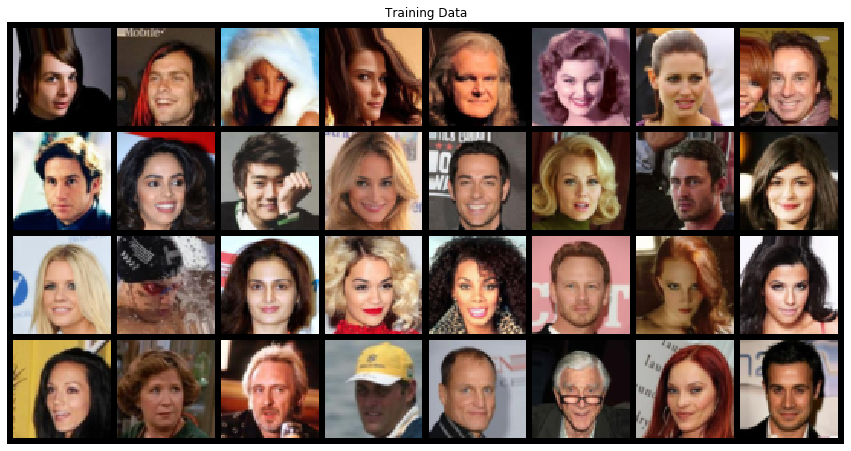

In [39]:
# Visualize some of the training data
plt.figure(figsize=(15, 8))
data, _ = next(iter(dataloader))

# Remove normalization from images and restore original images for correct visualization
# data = data * 0.5 + 0.5

grid = torchvision.utils.make_grid(data[:32], nrow=8, padding=4)
plt.imshow(grid.permute(1, 2, 0))
plt.title('Training Data')
plt.axis('off')
plt.show()

### Training

Loading and training the model. The full model structure is defined in the `celeba_model.py` file.

In [34]:
# Define the model 
latent_size = 100
model = ConvVAE(latent_size).to(device)
criterion = VAELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)

print(model)
print(len(dataset))

ConvVAE(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (encoder_fc1): Linear(in_features=4608, out_features=512, bias=True)
  (encoder_mu): Linear(in_features=512, out_features=100, bias=True)
  (encoder_logvar): Linear(in_features=512, out_features=100, bias=True)
  (decoder_fc1): Linear(in_features=100, out_features=512, bias=True)
  (decoder_fc2): Linear(in_features=512, out_features=4608, bias=True)
  (deconv1): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2))
)
60006


In [35]:
epochs = 2
for e in range(epochs):
    running_loss = 0
    for (idx, data) in enumerate(dataloader, 0):
        
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = model(x)

        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if idx % 10 == 0:
            print(f"Epoch {e}, Iteration {idx+1} / {len(dataset) // batch_size} \tLoss {running_loss / ((idx+1) * batch_size)}")


Epoch 0, Iteration 1 / 300 	Loss 3275.289375
Epoch 0, Iteration 11 / 300 	Loss 3063.6538920454545
Epoch 0, Iteration 21 / 300 	Loss 2790.3425
Epoch 0, Iteration 31 / 300 	Loss 2568.617137096774
Epoch 0, Iteration 41 / 300 	Loss 2366.442122713415
Epoch 0, Iteration 51 / 300 	Loss 2184.1203645833334
Epoch 0, Iteration 61 / 300 	Loss 2030.3024551741803
Epoch 0, Iteration 71 / 300 	Loss 1900.3038721390844
Epoch 0, Iteration 81 / 300 	Loss 1791.9421971450618
Epoch 0, Iteration 91 / 300 	Loss 1691.6383559409342
Epoch 0, Iteration 101 / 300 	Loss 1605.6721550123762
Epoch 0, Iteration 111 / 300 	Loss 1530.7801703265766
Epoch 0, Iteration 121 / 300 	Loss 1466.1381082128098
Epoch 0, Iteration 131 / 300 	Loss 1408.2193314646947
Epoch 0, Iteration 141 / 300 	Loss 1357.21093472961
Epoch 0, Iteration 151 / 300 	Loss 1310.5304465024835
Epoch 0, Iteration 161 / 300 	Loss 1269.0719545807453
Epoch 0, Iteration 171 / 300 	Loss 1232.7053198099416
Epoch 0, Iteration 181 / 300 	Loss 1199.9815463138812
Epoch

### Testing

Testing the learned model by generating new faces from the learned distribution. 

You can observe that the model learns to produce some kind of face. However, in typical VAE fashion the images are rather strongly blurred. Interestingly the model learned to predominantly generate female faces. 

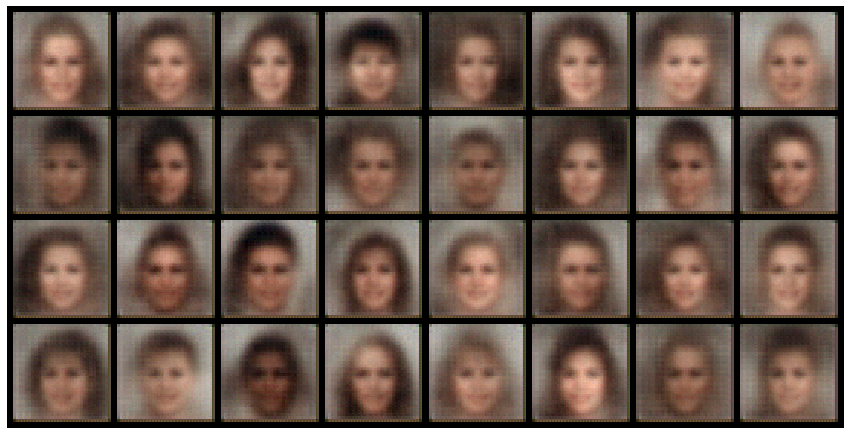

In [36]:
z_test = np.random.normal(size=(32, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

x_hat = model.decode(z_test)

# Remove normalization from images and restore original images for correct visualization
plt.figure(figsize=(15, 8))
grid = torchvision.utils.make_grid(x_hat, nrow=8, padding=4)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()
